
# Divison3: Classifying articles with Supervised Learning

### OBJECTIVES: Build and evaluate privacy classifier for DB


### ORGANIZATION: (files have only been added to Division1)
* ./DATA 
    * prod_training.csv (articles for training set) 
    * pri_250_db.csv (articles from privacy db)
    * _AGGREG (directory)
    * _PP  (dir)
    * _GOVT_SURV  (dir)
    * _BLCKMLnRAN  (dir)
    * _BREACH  (dir)
    * _DC  (dir)
    * _HARMFUL_TRTH  (dir)

* ./CORPUSES
* ./MODELS
* requirements.txt
* create_corpus.py
* create_models.py

### ATTRIBUTIONS
The model training was based on gensim creator's online tutorials. Similar tutorials can be found at skikit-learn.org:
    http://radimrehurek.com/data_science_python/
  



### TODO 
1. Refining/Further analyzing classifier results
2. Dealing with issue of multilabel. http://scikit-learn.org/dev/modules/multiclass.html

### NOTE On Classification Results

The classifier does much better with the topics such as Breach, Harmful_TRTH, BlCKMLnRAN than it does with _AGGREG and _PP.

I sometimes struggled trying to make distinctions between issues of aggregation and companies' explicit privacy policies, and it is reflected in the classifier results.



# Understanding the Classifier  Labels
The labels for the training set are rouhly based on Solove's classification, where privacy is categorized by its proximity to the owner.

### Information Collection:
* Gov't Surveillance [**GOVT_SURV**]

* Other data collection [**DC**] ---> *like Google Street Cars*

### Information Processing:

* Aggregation (Combining data on a person) [**AGGREG**] ---> *this includes using data analytics to further
profit on a person’s data*

* Privacy Policy issues [**PP**]

### Information Dissemination:
* Exposure/ Disclosure --exposing truth that may be harmful [**HARMFUL_TRTH**]  ---> *think tyler clementi*

* A data breach or hack  [**BREACH**]

### Invasion:
* Blackmail/Ransom [**BLCKMLnRAN**]

*** What about articles that aren't privacy related at all! ***
> KIM: When a label for spam was introduced, it significantly decreased cross-validation scores, and  was therefore omitted here.

# The Training Articles

Aqcuired using bing scrape on keywords related to the labels above. 
The articles are located in **./DATA** and are characterized by labels. 

* **./DATA/_AGGREG** for  has 22 articles with the label  for **AGGREG** 
* **./DATA/_GOVT_SURV** for  has 44 articles 
* **./DATA/_DC** for  has 31 articles 
* **./DATA/_PP** for  has 18 articles 
* **./DATA/_HARMFUL_TRTH** for  has 9 articles 
* **./DATA/_BREACH** for  has 21 articles 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv, sys,os
from textblob import TextBlob
import pandas
import sklearn
import _pickle as cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve
from gensim.parsing.preprocessing import STOPWORDS



# Loading the Training Data

Let's load the data into a pandas dataframe. All the training articles I used have been provided to you. If you want to update the training set, you'll need to make a new csv where every line has LABEL, TITLE, ARTICLE.

**./DATA/prod_training.csv**  is  a .csv file for all the training articles, where each line is LABEL, TITLE, ARTICLE. 

    >ex line in prod_training.csv:
    
    _AGGREG, title_name, "and the story continues without commas", _PP, title2_name, "and the story keeps going"


In [2]:
#..........................('./DATA/prod_training.csv).............
articles = pandas.read_csv('/tmp/prod_training.csv', sep=',', names=["label","title","article"])
articles = articles.dropna()
articles.groupby('label').describe()

# NEED TO DEBUG WHY _AGGREG lists only 17 articels

article  \
label                                                                     
_AGGREG       count                                                  17   
              unique                                                 17   
              top     Photo\n\nMany economists see a data revolution...   
              freq                                                    1   
_BLCKMLnRAN   count                                                  12   
              unique                                                 11   
              top     Thank you for your interest in licensing Fortu...   
              freq                                                    2   
_BREACH       count                                                  21   
              unique                                                 21   
              top     SAN FRANCISCO — The RSA Security division of t...   
              freq                                                    1   
_DC           count                                                  31   
              unique                                                 31   
              top     SAN FRANCISCO — Google’s harvesting of e-mails...   
              freq                                                    1   
_GOVT_SURV    count                                                  44   
              unique                                                 44   
              top     The Foreign Intelligence Surveillance Court ha...   
              freq                                                    1   
_HARMFUL_TRTH count                                                   9   
              unique                                                  9   
              top     Cyberbullying is a worse problem among teenage...   
              freq                                                    1   
_PP           count                                                  17   
              unique                                                 16   
              top     Chat with us in Facebook Messenger. Find out w...   
              freq                                                    2   

                                                                  title  
label                                                                    
_AGGREG       count                                                  17  
              unique                                                 17  
              top      Feb_28_1994_A_Push_for_Surveillance_Software.txt  
              freq                                                    1  
_BLCKMLnRAN   count                                                  12  
              unique                                                 12  
              top     Aug_16_2016_Ransomware-as-a-service_allows_wan...  
              freq                                                    1  
_BREACH       count                                                  21  
              unique                                                 21  
              top     Mar_14_2014_Daily_Report:_Target_Missed_Warnin...  
              freq                                                    1  
_DC           count                                                  31  
              unique                                                 31  
              top                Jul_21_2012_Cellphone_Surveillance.txt  
              freq                                                    1  
_GOVT_SURV    count                                                  44  
              unique                                                 44  
              top     Mar_25_2014_Obama:_US_must_'win_back_the_trust...  
              freq                                                    1  
_HARMFUL_TRTH count                                                   9  
              unique                                                  9  
              top     Sep_22_2015_One

# Splittling the training set for cross-validation
## An infrastructure for our classifier 


In [35]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

def split_into_tokens(message):
    message = message.lower()
    words = TextBlob(message).words
    return [word.lemma for word in words]
 

# Pipeline for predictor: bow --> tfidf --> apply classifier 
    # CountVectorizer: "Convert a collection of text documents to a matrix of token counts"(scikit-learn.org)
    # Create training set with %90 percent of training article set; test on %10 percent
art_train, art_test, label_train, label_test = \
    train_test_split(articles['article'], articles['label'], test_size=.1)

 
# model infrastructure
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_tokens)),
    ('tfidf', TfidfTransformer()),
    ('classifier',  OneVsRestClassifier(LinearSVC()))  # <== This produced better results than SVC()
])



# Get cross validation score. 
## Train Classifier
Using a pipeline is commonly  used for scikit-learn model creation. However I need to provide credit to the .ipynb cited above, as its example pipeline was adapted for this project. 

In [36]:
# Train classifier 
pipeline_svm.fit(art_train, label_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function split_into_tokens at 0xa59492fc>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=N...lti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1))])

In [37]:
# Get Cross Validation Scores
scores = cross_val_score(pipeline_svm,  # "steps to convert raw messages into models"
                         art_train,     # "training data"
                         label_train,   # "training labels"
                         cv=5,          #  "split data randomly into 5 parts: 4 for training, 1 for scoring"
                         scoring='accuracy',  # "which scoring metric?"
                         n_jobs=-1,     # "-1 = use all cores = faster"
                         )
print(scores)


[ 0.76666667  0.67857143  0.81481481  0.84        0.84      ]


How much do our predictive powers increase as we increase our training base? 


In [38]:
# KIM: the following function is almost ENTIRELY taken from the above cited tutorial
#       it is a useful visualization

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    #
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



CPU times: user 320 ms, sys: 116 ms, total: 436 ms
Wall time: 44.4 s


<module 'matplotlib.pyplot' from '/home/adi/.virtualenvs/scraper/lib/python3.4/site-packages/matplotlib/pyplot.py'>

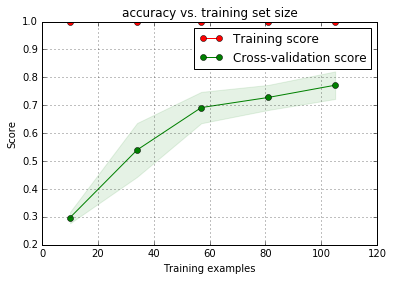

In [40]:
%time plot_learning_curve(pipeline_svm, "accuracy vs. training set size", art_train, label_train, cv=5)

# Create an instance of our predictor

In [39]:
svm_detector = pipeline_svm


# Predicting labels in the DB
Let's finally predict labels for the article in our privacy database. 

In [41]:
# cp ./DATA/pri_250_db.csv /tmp/pri_250_db.csv
articlesDB = pandas.read_csv('/tmp/pri_250_db.csv', sep=',', names=["title","article"])
articlesDB['predicted'] = svm_detector.predict(articlesDB['article'])
pandas.options.display.max_colwidth = 100
articlesDB.groupby('predicted').describe()


article  \
predicted                                                                                                                   
_AGGREG       count                                                                                                    15   
              unique                                                                                                   15   
              top     Is Your Android Device Telling the World Where You've Been? | Electronic Frontier Foundation\nIs...   
              freq                                                                                                      1   
_BLCKMLnRAN   count                                                                                                     2   
              unique                                                                                                    2   
              top     Comcast agrees to pay $33 million in California privacy breach - LA Times\nGet unlimited digital...   
              freq                                                                                                      1   
_BREACH       count                                                                                                    27   
              unique                                                                                                   23   
              top     You probably heard about the Target data breach that put the credit-card numbers and personal in...   
              freq                                                                                                      5   
_DC           count                                                                                                    38   
              unique                                                                                                   29   
              top                                                                                                      \n   
              freq                                                                                                      8   
_GOVT_SURV    count                                                                                                    30   
              unique                                                                                                   29   
              top     Promise and Concern for Vast Social Services Database on Citys Neediest - The New York Times\nNY...   
              freq                                                                                                      2   
_HARMFUL_TRTH count                                                                                                    16   
              unique                                                                                                   16   
              top     De-Friendly Fire: American University student makes Facebook rape accusation - The Sexist\nD.C. ...   
              freq                                                                                                      1   
_PP           count                                                                                                    59   
              unique                                                                                                   58   
              top     LinkedIn's iPhone App Sparks Latest Privacy Controversy Over Mobile Devices\nLinkedIn's iPhone A...   
              freq                                                                                                      2   

                                                                       title  
predicted                                                                     
_AGGREG       count                                                       15  
              unique                                                      15  
              top     orbitz uses the type of m

# Visualize Results

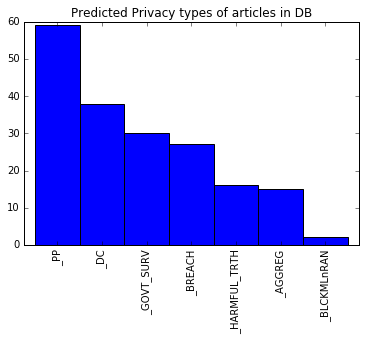

In [42]:
articlesDB['predicted'].value_counts().plot(kind='bar',width=1.0).set_title("Predicted Privacy types of articles in DB")

In [43]:
articlesDB[articlesDB.predicted=="_BREACH"]['title']

pri_250_db    adultfriendfinder website hacked, pii accessed, at.txt
pri_250_db       hackers accessed pii of 102m playstation users..txt
pri_250_db    breach of epsilon data exposes names and email add.txt
pri_250_db    global information services group experian was att.txt
pri_250_db                 50m living social records compromised.txt
pri_250_db    security breach leasks credit card numbers, as wel.txt
pri_250_db           nude snapchat images put online by hackers..txt
pri_250_db    56m payment cards compromised by malware infected .txt
pri_250_db    military bases are using ssns as identifiers in a .txt
pri_250_db    healthfirst, is notifying approximately 5300 affec.txt
pri_250_db    130m credit and debit cards stored by heartland pa.txt
pri_250_db    hacker accesses records of 15m t-mobile customers .txt
pri_250_db    blippy, a social media service that facilitates sh.txt
pri_250_db              data breach at tampa general hospital.\n.txt
pri_250_db    southern phone compa

In [44]:
articlesDB[articlesDB.predicted=="_BLCKMLnRAN"]['title']

pri_250_db    hiv clinic accidentally disclosed 780 hiv patients.txt
pri_250_db    comcast exposed pii of customers who had paid to k.txt
Name: title, dtype: object

In [45]:
articlesDB[articlesDB.predicted=="_HARMFUL_TRTH"]['title']

pri_250_db    callisto service allows victims of sexual assault .txt
pri_250_db    high school student victim of sexual abuse outs pe.txt
pri_250_db    english women posts revenge porn pictures on faceb.txt
pri_250_db    high school student in saratoga, ca, was victim of.txt
pri_250_db    a newspaper publishes sexual images of max mosley .txt
pri_250_db    dorm mates of tyler clementi secretly video record.txt
pri_250_db    google doodle contest asks for last 4 digits of ss.txt
pri_250_db    us high school teacher forced to resign or be susp.txt
pri_250_db    canadian teenager was raped and rapists distribute.txt
pri_250_db    american university accused rapist outed on facebo.txt
pri_250_db    blood test of mother of dead newborn used to convi.txt
pri_250_db    target uses purchases to infer pregnancy, promotes.txt
pri_250_db    former classmate buys amy boyer's ssn and employer.txt
pri_250_db    drone spotted near a school raises privacy and saf.txt
pri_250_db    user misunderstandin

In [46]:
articlesDB[articlesDB.predicted=="_GOVT_SURV"]['title']

pri_250_db    a database about needy nyc residents that aggregat.txt
pri_250_db    a start-up that makes it easier for employers to r.txt
pri_250_db    judge orders twitter to give information about 3 a.txt
pri_250_db    united arab emirates announces it will suspend bla.txt
pri_250_db    new law requires companies to store data about rus.txt
pri_250_db    same-sex marriage opponents protest requests to tu.txt
pri_250_db    growth of mugshot sites, that use public records t.txt
pri_250_db    police used text messages on victim's phone to cha.txt
pri_250_db    the us supreme court upholds the practice of intru.txt
pri_250_db    us pressures pakistan to provide more detailed inf.txt
pri_250_db    netflix released data  of user movie ratings with .txt
pri_250_db    emails of faculty and staff at harvard were search.txt
pri_250_db    a us government employee accidentally sent a file .txt
pri_250_db    topless sunbathing photos of kate middleton are pu.txt
pri_250_db    a man was charged wi

In [47]:
articlesDB[articlesDB.predicted=="_AGGREG"]['title']

pri_250_db    orbitz uses the type of machine making the request.txt
pri_250_db    call centers analyzing voice data for emotional st.txt
pri_250_db    default privacy setting allows fitbit profiles to .txt
pri_250_db    e-readers found to be collecting detailed data abo.txt
pri_250_db    some android phones found to be broadcasting locat.txt
pri_250_db    voter registration information exposed for 191m am.txt
pri_250_db    audit by the state of north carolina of consumer p.txt
pri_250_db    quora new feature displaying who has viewed a post.txt
pri_250_db    adblock plus, an ad-blocking app, removed from the.txt
pri_250_db    calls to understand insurance coverage appear to d.txt
pri_250_db    script made available for determining ip address o.txt
pri_250_db    linkedin defaults, confusing privacy wording in se.txt
pri_250_db    new ability to email google+ contacts whose email .txt
pri_250_db    increasing number of fraudsters posing as call cen.txt
pri_250_db    ubuntu version autom

In [48]:
articlesDB[articlesDB.predicted=="_DC"]['title']

pri_250_db    call-center workers for at&t inc. leaked confident.txt
pri_250_db    google search autocomplete links german prime mini.txt
pri_250_db    predictive assistant introduced, google now, perce.txt
pri_250_db    kid-directed websites found to set more cookies th.txt
pri_250_db    european plans for a terrorist tracking system rai.txt
pri_250_db    laptop with patient data stolen from northwestern .txt
pri_250_db    several facebook apps (e.g. farmville) found to be.txt
pri_250_db    iphones found to be storing user location data for.txt
pri_250_db    some users of google talk and google hangout had c.txt
pri_250_db    google streetview cars accidentally collected wifi.txt
pri_250_db    instances of home surveillance footage showing mis.txt
pri_250_db    awareness grows over volume of data collected by c.txt
pri_250_db    google buzz exposed contacts of users who didn't c.txt
pri_250_db    google play is discovered to share email addresses.txt
pri_250_db    flash drive with emp

In [49]:
articlesDB[articlesDB.predicted=="_PP"]['title']

pri_250_db    playdom amasssed and divulged pii of children who .txt
pri_250_db    facebook releases "signal" a product that aggregat.txt
pri_250_db    carefirst bluecross blueshield hacking incident; i.txt
pri_250_db    consumers voice privacy concerns about online reta.txt
pri_250_db    news of the world reporters found to be hacking vo.txt
pri_250_db    in some cases, the facebook user id could be infer.txt
pri_250_db    a google advertiser targeted users based on health.txt
pri_250_db    microsoft reviews user emails as part of an invest.txt
pri_250_db    facebook begins using face recognition to automati.txt
pri_250_db    eli lilli accidentally discloses email addresses o.txt
pri_250_db    disconnect mobile, an ad-blocking app, removed fro.txt
pri_250_db    hulu sharing video watching histories, along with .txt
pri_250_db    twitter changes "block" functionality to allow blo.txt
pri_250_db    youtube comments begin requiring a google+ account.txt
pri_250_db    research project fin